# Image Generation with GAN

In [10]:
from datasets import load_dataset,DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
import random
import torchvision.transforms as transforms
import torchvision.utils
import utils
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import time

In [11]:
##################
##Hyperparamets 
##################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 20
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3

Device: cuda:0


## Dataset

In [12]:
custom_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = utils.ImageDataset("human_face_generation_split/preprocessed/train",transform=custom_transforms)
val_dataset = utils.ImageDataset("human_face_generation_split/raw/validation",transform=custom_transforms)
test_dataset = utils.ImageDataset("human_face_generation_split/raw/test",transform=custom_transforms)
show_dataset = utils.ImageDataset("human_face_generation_split/show_imgs/train" ,transform=custom_transforms)

train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=4,shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset,batch_size=4,shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)
show_data =torch.utils.data.DataLoader(show_dataset)


In [13]:
# Checking the dataset
print('Training Set:\n')
for images in train_data_loader:  
    print('Image batch dimensions:', images.size())
   # print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images in val_data_loader:   
    print('Image batch dimensions:', images.size())
    #print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images in test_data_loader:  
    print('Image batch dimensions:', images.size())
  #  print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([4, 3, 64, 64])

Validation Set:
Image batch dimensions: torch.Size([4, 3, 64, 64])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 64, 64])


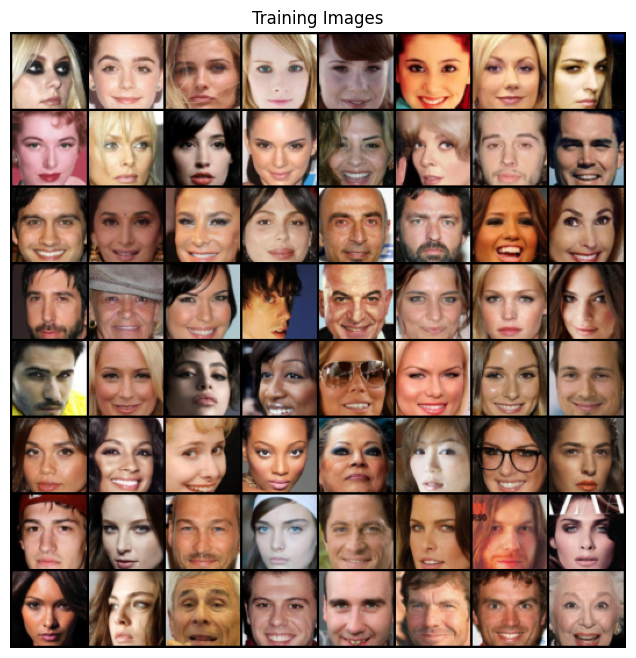

In [14]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

# Model Architecture

In [15]:
class DCGAN(torch.nn.Module):
    def __init__(self,latent_dim = 100, num_feat_maps_gen = 64,
                 num_feat_maps_dis = 64 , color_channels =3):
        super().__init__()

        self.gen = nn.Sequential(
            # Input: (latent_dim) x 1 x 1
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen * 8, 
                               kernel_size = 4,stride =  1, padding= 0, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen * 8),
            nn.LeakyReLU(inplace=True),

            # (num_feat_maps_gen * 8) x 4 x 4
            nn.ConvTranspose2d(num_feat_maps_gen * 8, num_feat_maps_gen * 4, 
                            kernel_size = 4,stride =  1, padding= 1, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen * 4),
            nn.LeakyReLU(inplace=True), 
            
            nn.ConvTranspose2d(num_feat_maps_gen * 4, num_feat_maps_gen * 2, 
                            kernel_size = 4,stride =  2, padding= 1, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen * 2),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen *2, num_feat_maps_gen, 
                            kernel_size = 4,stride =  2, padding= 1, bias=False),
            nn.BatchNorm2d(num_feat_maps_gen * 4),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(num_feat_maps_gen , color_channels , 
                            kernel_size = 4,stride =  2, padding= 1, bias=False),
          
            nn.Tanh()
        )
        self.disc = nn.Sequential(
            nn.Conv2d (color_channels, num_feat_maps_dis,
                       kernel_size= 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d (num_feat_maps_dis, num_feat_maps_dis*2,
                       kernel_size= 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d (num_feat_maps_dis*2, num_feat_maps_dis*4,
                       kernel_size= 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d (num_feat_maps_dis*4, num_feat_maps_dis*8,
                       kernel_size= 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d (num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),

            
            nn.Conv2d (num_feat_maps_dis*8, 1,
                       kernel_size= 4, stride = 2, padding = 0, bias=False),
            nn.Flatten(),
        )
            
    def gen_forwards(self,z):
        img = self.gen(z)
        return img
    def disc_forward(self,img):
        logits = model.disc(img)
        return logits
    

In [17]:
utils.set_all_seeds(RANDOM_SEED)

model = DCGAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.gen.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.disc.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)